In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

import time
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import datetime
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.backend import batch_normalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from packaging import version
%matplotlib inline

In [2]:
#identify GPU
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Found GPU at: /device:GPU:0


In [3]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join('Data_new3', 'X_train.npy'))
    labels = np.load(os.path.join('Data_new3', 'train_labels_multi.npy'))
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join('Data_new3', 'X_test.npy'))
    labels = np.load(os.path.join('Data_new3', 'y_test_labels_multi.npy'))
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [69]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 2913 	 Test size: 655
Image size: 256x256


In [70]:
test_labels

array([2, 0, 2, 0, 1, 1, 0, 2, 0, 3, 1, 3, 1, 3, 2, 0, 0, 1, 0, 1, 2, 2,
       1, 2, 2, 1, 1, 3, 0, 1, 3, 0, 2, 1, 3, 3, 1, 0, 3, 0, 3, 2, 1, 0,
       0, 3, 0, 2, 2, 2, 0, 2, 2, 1, 1, 2, 2, 3, 3, 1, 3, 0, 1, 3, 1, 1,
       2, 2, 3, 1, 1, 0, 1, 0, 2, 1, 2, 0, 1, 0, 1, 1, 3, 2, 3, 3, 2, 0,
       3, 1, 0, 0, 0, 2, 0, 0, 3, 2, 2, 0, 1, 0, 0, 1, 1, 1, 0, 3, 0, 0,
       0, 3, 3, 2, 2, 2, 0, 3, 3, 0, 2, 1, 3, 1, 2, 2, 0, 0, 3, 1, 1, 2,
       1, 0, 3, 0, 2, 0, 2, 2, 0, 3, 3, 3, 1, 0, 2, 0, 0, 0, 0, 1, 0, 3,
       2, 3, 0, 1, 2, 0, 1, 0, 1, 3, 2, 0, 0, 0, 0, 2, 3, 3, 1, 0, 3, 3,
       3, 1, 2, 3, 3, 1, 1, 0, 1, 2, 1, 0, 3, 0, 0, 0, 3, 2, 1, 1, 1, 3,
       0, 2, 2, 2, 0, 0, 2, 0, 3, 2, 1, 0, 3, 1, 2, 0, 0, 3, 2, 1, 2, 1,
       1, 3, 2, 1, 0, 3, 3, 2, 0, 2, 2, 1, 1, 1, 1, 2, 2, 3, 2, 3, 1, 1,
       0, 0, 1, 0, 2, 3, 3, 0, 1, 0, 3, 2, 3, 0, 2, 2, 3, 0, 0, 2, 1, 2,
       3, 1, 2, 1, 0, 1, 3, 0, 1, 2, 1, 3, 0, 0, 0, 1, 2, 1, 2, 3, 0, 0,
       3, 0, 3, 0, 1, 0, 0, 2, 1, 0, 1, 2, 2, 0, 0,

In [71]:
# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [72]:
train_images.shape

(2913, 256, 256, 1)

In [73]:
# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [74]:
# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16') / 256
test_images = test_images.astype('uint16') / 256

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [88]:
# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [91]:
# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

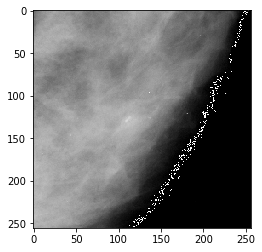

Label: [0. 0. 1. 0.]
[[[101.88671875 101.88671875 101.88671875]
  [105.91796875 105.91796875 105.91796875]
  [107.90625    107.90625    107.90625   ]
  ...
  [255.99609375 255.99609375 255.99609375]
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]]

 [[106.14453125 106.14453125 106.14453125]
  [108.34765625 108.34765625 108.34765625]
  [112.53125    112.53125    112.53125   ]
  ...
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]]

 [[106.27734375 106.27734375 106.27734375]
  [113.1484375  113.1484375  113.1484375 ]
  [113.78515625 113.78515625 113.78515625]
  ...
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]]

 ...

 [[178.640625   178.640625   178.640625  ]
  [179.3828125  179.3828125  179.3828125 ]
  [177.22265625 177.22265625 177.22265625]
  ...
  [  0.           0.           0.       

In [16]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))
print(train_images[0])

In [17]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_vgg16(verbose=False, fc_size=256, dropout=None):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))

    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(4, activation='softmax'))

    # Freeze the convolutional base
    vgg16_base.trainable = False

    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

In [18]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_128 = create_vgg16(dropout=0.5, fc_size=256)

In [19]:
vgg16_fe_drop_128.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 8,389,892
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_128_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_128.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Train
history_vgg16_fe_drop_128 = vgg16_fe_drop_128.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 10.2438 - accuracy: 0.3159
Epoch 00001: val_loss improved from inf to 1.36241, saving model to vgg16_fe_drop_128_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 9.7986 - accuracy: 0.3153 - val_loss: 1.3624 - val_accuracy: 0.3436
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.4075 - accuracy: 0.3404
Epoch 00002: val_loss improved from 1.36241 to 1.36015, saving model to vgg16_fe_drop_128_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.4071 - accuracy: 0.3393 - val_loss: 1.3602 - val_accuracy: 0.3522
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3782 - accuracy: 0.3454
Epoch 00003: val_loss did not improve from 1.36015
19/19 [==============================] - 29s 2s/step - loss: 1.3781 - accuracy: 0.3462 - val_loss: 1.3927 - val_ac

Epoch 29/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2079 - accuracy: 0.4535
Epoch 00029: val_loss did not improve from 1.22895
19/19 [==============================] - 28s 1s/step - loss: 1.2101 - accuracy: 0.4556 - val_loss: 1.2298 - val_accuracy: 0.4777
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2317 - accuracy: 0.4435
Epoch 00030: val_loss improved from 1.22895 to 1.19751, saving model to vgg16_fe_drop_128_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.2283 - accuracy: 0.4457 - val_loss: 1.1975 - val_accuracy: 0.4674
Epoch 31/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2042 - accuracy: 0.4607
Epoch 00031: val_loss did not improve from 1.19751
19/19 [==============================] - 29s 2s/step - loss: 1.1952 - accuracy: 0.4650 - val_loss: 1.2452 - val_accuracy: 0.4381
Epoch 32/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2099 - accuracy: 0.4548
Epoch 00032: val_loss did

18/19 [===========================>..] - ETA: 1s - loss: 1.1820 - accuracy: 0.4843
Epoch 00058: val_loss did not improve from 1.18782
19/19 [==============================] - 29s 2s/step - loss: 1.1847 - accuracy: 0.4843 - val_loss: 1.2149 - val_accuracy: 0.4244
Epoch 59/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1635 - accuracy: 0.4689
Epoch 00059: val_loss did not improve from 1.18782
19/19 [==============================] - 29s 2s/step - loss: 1.1617 - accuracy: 0.4710 - val_loss: 1.2231 - val_accuracy: 0.4227
Epoch 60/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1769 - accuracy: 0.4822
Epoch 00060: val_loss did not improve from 1.18782
19/19 [==============================] - 28s 1s/step - loss: 1.1712 - accuracy: 0.4839 - val_loss: 1.2309 - val_accuracy: 0.4347
Epoch 61/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1688 - accuracy: 0.4807
Epoch 00061: val_loss did not improve from 1.18782
19/19 [==============================]

Epoch 88/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1440 - accuracy: 0.5043
Epoch 00088: val_loss improved from 1.17034 to 1.15541, saving model to vgg16_fe_drop_128_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.1423 - accuracy: 0.5066 - val_loss: 1.1554 - val_accuracy: 0.4794
Epoch 89/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1813 - accuracy: 0.4807
Epoch 00089: val_loss did not improve from 1.15541
19/19 [==============================] - 29s 2s/step - loss: 1.1777 - accuracy: 0.4805 - val_loss: 1.2201 - val_accuracy: 0.4777
Epoch 90/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1448 - accuracy: 0.4889
Epoch 00090: val_loss did not improve from 1.15541
19/19 [==============================] - 28s 1s/step - loss: 1.1482 - accuracy: 0.4886 - val_loss: 1.2235 - val_accuracy: 0.4622
Epoch 91/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1533 - accuracy: 0.4848
Epoch 00091: val_loss did

18/19 [===========================>..] - ETA: 1s - loss: 1.1437 - accuracy: 0.4930
Epoch 00117: val_loss did not improve from 1.13728
19/19 [==============================] - 29s 2s/step - loss: 1.1413 - accuracy: 0.4942 - val_loss: 1.1794 - val_accuracy: 0.4863
Epoch 118/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1512 - accuracy: 0.4939
Epoch 00118: val_loss did not improve from 1.13728
19/19 [==============================] - 29s 2s/step - loss: 1.1510 - accuracy: 0.4946 - val_loss: 1.1672 - val_accuracy: 0.4880
Epoch 119/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1255 - accuracy: 0.5111
Epoch 00119: val_loss did not improve from 1.13728
19/19 [==============================] - 29s 2s/step - loss: 1.1298 - accuracy: 0.5105 - val_loss: 1.1838 - val_accuracy: 0.4622
Epoch 120/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1243 - accuracy: 0.5070
Epoch 00120: val_loss did not improve from 1.13728
19/19 [============================

In [24]:
# Save
models.save_model(vgg16_fe_drop_128, 'vgg16_fe_drop_128_4cl_end.h5')

In [26]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_128.history['loss']
tra_acc_fe = history_vgg16_fe_drop_128.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_128.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_128.history['val_accuracy']

In [27]:
# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_128 = models.load_model('vgg16_fe_drop_128_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

In [28]:
print("VGG16 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 139
Epoch [opt]: 109
Valid accuracy [end]: 0.4777
Valid accuracy [opt]: 0.4931
Test accuracy [end]:  0.4672
Test accuracy [opt]:  0.4855
Valid loss [end]: 1.1915
Valid loss [opt]: 1.1373
Test loss [end]:  1.1673
Test loss [opt]:  1.1346


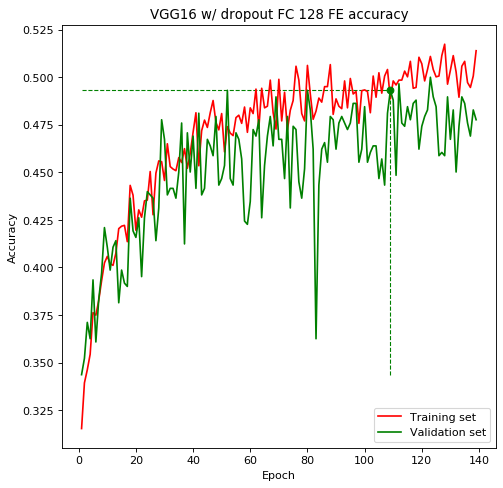

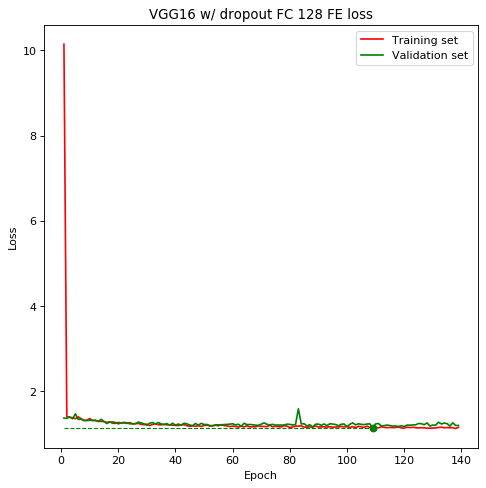

In [29]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [33]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_256 = create_vgg16(dropout=0.5, fc_size=128)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_256_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_256.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
# Train
history_vgg16_fe_drop_256 = vgg16_fe_drop_256.fit_generator(
        train_generator,
        epochs=150,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/150
18/19 [===========================>..] - ETA: 1s - loss: 9.0313 - accuracy: 0.3087
Epoch 00001: val_loss improved from inf to 1.38103, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 8.6441 - accuracy: 0.3089 - val_loss: 1.3810 - val_accuracy: 0.3110
Epoch 2/150
18/19 [===========================>..] - ETA: 1s - loss: 1.4123 - accuracy: 0.3442
Epoch 00002: val_loss did not improve from 1.38103
19/19 [==============================] - 29s 2s/step - loss: 1.4072 - accuracy: 0.3445 - val_loss: 1.3820 - val_accuracy: 0.3608
Epoch 3/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3942 - accuracy: 0.3559
Epoch 00003: val_loss improved from 1.38103 to 1.34844, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.3874 - accuracy: 0.3608 - val_loss: 1.3484 - val_acc

Epoch 28/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2291 - accuracy: 0.4417
Epoch 00028: val_loss did not improve from 1.21657
19/19 [==============================] - 29s 2s/step - loss: 1.2318 - accuracy: 0.4423 - val_loss: 1.2284 - val_accuracy: 0.4725
Epoch 29/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2187 - accuracy: 0.4562
Epoch 00029: val_loss did not improve from 1.21657
19/19 [==============================] - 29s 2s/step - loss: 1.2181 - accuracy: 0.4560 - val_loss: 1.2232 - val_accuracy: 0.4450
Epoch 30/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2292 - accuracy: 0.4548
Epoch 00030: val_loss did not improve from 1.21657
19/19 [==============================] - 29s 2s/step - loss: 1.2307 - accuracy: 0.4530 - val_loss: 1.2387 - val_accuracy: 0.4467
Epoch 31/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2235 - accuracy: 0.4423
Epoch 00031: val_loss did not improve from 1.21657
19/19 [==================

18/19 [===========================>..] - ETA: 1s - loss: 1.1859 - accuracy: 0.4689
Epoch 00057: val_loss did not improve from 1.18110
19/19 [==============================] - 29s 2s/step - loss: 1.1875 - accuracy: 0.4689 - val_loss: 1.2099 - val_accuracy: 0.4399
Epoch 58/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1961 - accuracy: 0.4730
Epoch 00058: val_loss improved from 1.18110 to 1.17956, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.1949 - accuracy: 0.4762 - val_loss: 1.1796 - val_accuracy: 0.4725
Epoch 59/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1956 - accuracy: 0.4562
Epoch 00059: val_loss did not improve from 1.17956
19/19 [==============================] - 29s 2s/step - loss: 1.1932 - accuracy: 0.4569 - val_loss: 1.1909 - val_accuracy: 0.4674
Epoch 60/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2059 - accuracy: 0.4580
Epoch 00060: val_loss did not improve 

Epoch 87/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1761 - accuracy: 0.4757
Epoch 00087: val_loss did not improve from 1.17411
19/19 [==============================] - 29s 2s/step - loss: 1.1803 - accuracy: 0.4732 - val_loss: 1.2072 - val_accuracy: 0.4811
Epoch 88/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1833 - accuracy: 0.4744
Epoch 00088: val_loss did not improve from 1.17411
19/19 [==============================] - 29s 2s/step - loss: 1.1858 - accuracy: 0.4723 - val_loss: 1.2161 - val_accuracy: 0.4553
Epoch 89/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1942 - accuracy: 0.4666
Epoch 00089: val_loss did not improve from 1.17411
19/19 [==============================] - 29s 2s/step - loss: 1.1909 - accuracy: 0.4676 - val_loss: 1.2493 - val_accuracy: 0.4381
Epoch 90/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1832 - accuracy: 0.4607
Epoch 00090: val_loss did not improve from 1.17411
19/19 [==================

In [ ]:
# Save
models.save_model(vgg16_fe_drop_256, 'vgg16_fe_drop_256_4cl_end.h5')

In [35]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_256.history['loss']
tra_acc_fe = history_vgg16_fe_drop_256.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_256.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_256.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_256 = models.load_model('vgg16_fe_drop_256_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)

print("VGG16 (w/ dropout) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout) Feature Extraction

Epoch [end]: 93
Epoch [opt]: 63
Valid accuracy [end]: 0.4742
Valid accuracy [opt]: 0.4622
Test accuracy [end]:  0.4733
Test accuracy [opt]:  0.4763
Valid loss [end]: 1.1836
Valid loss [opt]: 1.1741
Test loss [end]:  1.1542
Test loss [opt]:  1.1580


In [36]:
vgg16_ft_1layer = models.load_model('vgg16_fe_drop_128_4cl_best.h5')

# Fine tuning: unfreeze the last convolutional layer
for layer in vgg16_ft_1layer.get_layer('vgg16').layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_1layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_1layer.summary()
vgg16_ft_1layer.get_layer('vgg16').summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 10,749,700
Non-trainable params: 12,354,880
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)      

In [43]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_1layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [44]:
# Train
history_ft = vgg16_ft_1layer.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0861 - accuracy: 0.5306
Epoch 00001: val_loss improved from inf to 1.17535, saving model to vgg16_ft_1layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.0835 - accuracy: 0.5294 - val_loss: 1.1753 - val_accuracy: 0.4880
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0691 - accuracy: 0.5361
Epoch 00002: val_loss improved from 1.17535 to 1.12703, saving model to vgg16_ft_1layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.0685 - accuracy: 0.5354 - val_loss: 1.1270 - val_accuracy: 0.5069
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0558 - accuracy: 0.5483
Epoch 00003: val_loss did not improve from 1.12703
19/19 [==============================] - 29s 2s/step - loss: 1.0545 - accuracy: 0.5508 - val_loss: 1.1477 - val_accurac

Epoch 29/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9527 - accuracy: 0.5901
Epoch 00029: val_loss did not improve from 1.08309
19/19 [==============================] - 29s 2s/step - loss: 0.9608 - accuracy: 0.5873 - val_loss: 1.0980 - val_accuracy: 0.5464
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9432 - accuracy: 0.5906
Epoch 00030: val_loss did not improve from 1.08309
19/19 [==============================] - 29s 2s/step - loss: 0.9483 - accuracy: 0.5899 - val_loss: 1.1245 - val_accuracy: 0.5584
Epoch 31/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9680 - accuracy: 0.6005
Epoch 00031: val_loss did not improve from 1.08309
19/19 [==============================] - 29s 2s/step - loss: 0.9659 - accuracy: 0.5993 - val_loss: 1.1337 - val_accuracy: 0.4983
Epoch 32/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9476 - accuracy: 0.5983
Epoch 00032: val_loss did not improve from 1.08309
19/19 [==================

18/19 [===========================>..] - ETA: 1s - loss: 0.8985 - accuracy: 0.6119
Epoch 00058: val_loss did not improve from 1.05692
19/19 [==============================] - 28s 1s/step - loss: 0.8946 - accuracy: 0.6152 - val_loss: 1.1337 - val_accuracy: 0.5292
Epoch 59/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8910 - accuracy: 0.6228
Epoch 00059: val_loss improved from 1.05692 to 1.05624, saving model to vgg16_ft_1layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 0.8898 - accuracy: 0.6225 - val_loss: 1.0562 - val_accuracy: 0.5533
Epoch 60/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9042 - accuracy: 0.6151
Epoch 00060: val_loss did not improve from 1.05624
19/19 [==============================] - 29s 2s/step - loss: 0.9073 - accuracy: 0.6135 - val_loss: 1.1043 - val_accuracy: 0.5464
Epoch 61/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8952 - accuracy: 0.6237
Epoch 00061: val_loss did not improve fr

18/19 [===========================>..] - ETA: 1s - loss: 0.8678 - accuracy: 0.6396
Epoch 00087: val_loss did not improve from 1.01914
19/19 [==============================] - 29s 2s/step - loss: 0.8657 - accuracy: 0.6405 - val_loss: 1.0368 - val_accuracy: 0.5808
Epoch 88/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8622 - accuracy: 0.6446
Epoch 00088: val_loss did not improve from 1.01914
19/19 [==============================] - 29s 2s/step - loss: 0.8593 - accuracy: 0.6482 - val_loss: 1.0701 - val_accuracy: 0.5704
Epoch 89/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8591 - accuracy: 0.6414
Epoch 00089: val_loss did not improve from 1.01914
19/19 [==============================] - 29s 2s/step - loss: 0.8605 - accuracy: 0.6392 - val_loss: 1.0448 - val_accuracy: 0.5550
Epoch 90/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8320 - accuracy: 0.6609
Epoch 00090: val_loss did not improve from 1.01914
19/19 [==============================]

In [45]:
# Save
models.save_model(vgg16_ft_1layer, 'vgg16_ft_1layer_4cl_end.h5')

In [47]:
# History of accuracy and loss
tra_loss_fe = history_ft.history['loss']
tra_acc_fe = history_ft.history['accuracy']
val_loss_fe = history_ft.history['val_loss']
val_acc_fe = history_ft.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_1layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 105
Epoch [opt]: 75
Valid accuracy [end]: 0.5859
Valid accuracy [opt]: 0.5876
Test accuracy [end]:  0.5221
Test accuracy [opt]:  0.5756
Valid loss [end]: 1.0784
Valid loss [opt]: 1.0191
Test loss [end]:  1.1705
Test loss [opt]:  1.0373


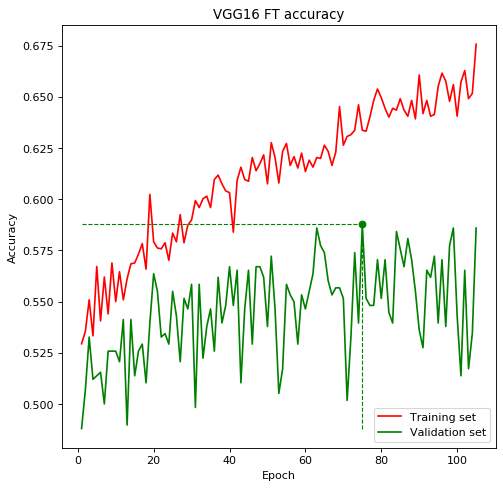

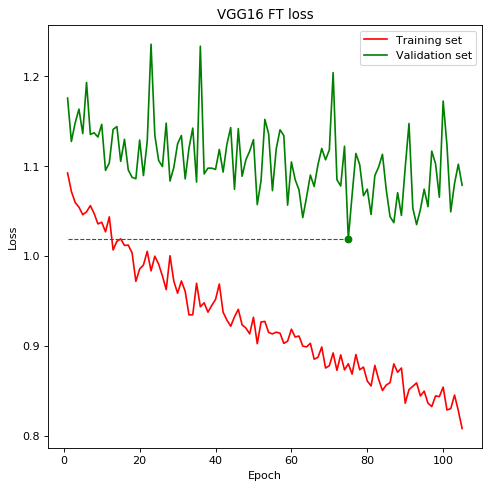

In [48]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [49]:
vgg16_ft_2layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_2layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_2layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_2layer.summary()
vgg16_ft_2layer.get_layer('vgg16').summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 13,109,508
Non-trainable params: 9,995,072
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)       

In [52]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_2layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [54]:
# Train
history_ft_2layer = vgg16_ft_2layer.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9651 - accuracy: 0.5874
Epoch 00001: val_loss improved from inf to 1.03341, saving model to vgg16_ft_2layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 0.9642 - accuracy: 0.5869 - val_loss: 1.0334 - val_accuracy: 0.5790
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9674 - accuracy: 0.6005
Epoch 00002: val_loss did not improve from 1.03341
19/19 [==============================] - 29s 2s/step - loss: 0.9712 - accuracy: 0.5993 - val_loss: 1.0824 - val_accuracy: 0.5241
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9387 - accuracy: 0.6146
Epoch 00003: val_loss did not improve from 1.03341
19/19 [==============================] - 29s 2s/step - loss: 0.9421 - accuracy: 0.6122 - val_loss: 1.2151 - val_accuracy: 0.4742
Epoch 4/200
18/19 [====================

19/19 [==============================] - 29s 2s/step - loss: 0.8271 - accuracy: 0.6594 - val_loss: 1.0128 - val_accuracy: 0.5756
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8511 - accuracy: 0.6491
Epoch 00030: val_loss did not improve from 1.01279
19/19 [==============================] - 29s 2s/step - loss: 0.8623 - accuracy: 0.6439 - val_loss: 1.0379 - val_accuracy: 0.5945
Epoch 31/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8072 - accuracy: 0.6632
Epoch 00031: val_loss did not improve from 1.01279
19/19 [==============================] - 29s 2s/step - loss: 0.8141 - accuracy: 0.6598 - val_loss: 1.1448 - val_accuracy: 0.5498
Epoch 32/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8268 - accuracy: 0.6555
Epoch 00032: val_loss did not improve from 1.01279
19/19 [==============================] - 29s 2s/step - loss: 0.8369 - accuracy: 0.6521 - val_loss: 1.0985 - val_accuracy: 0.5636
Epoch 33/200
18/19 [=======================

18/19 [===========================>..] - ETA: 1s - loss: 0.7723 - accuracy: 0.6918
Epoch 00059: val_loss did not improve from 0.99925
19/19 [==============================] - 29s 2s/step - loss: 0.7752 - accuracy: 0.6911 - val_loss: 1.2414 - val_accuracy: 0.5361
Epoch 60/200
18/19 [===========================>..] - ETA: 1s - loss: 0.7871 - accuracy: 0.6827
Epoch 00060: val_loss did not improve from 0.99925
19/19 [==============================] - 29s 2s/step - loss: 0.7864 - accuracy: 0.6830 - val_loss: 1.0325 - val_accuracy: 0.5842
Epoch 61/200
18/19 [===========================>..] - ETA: 1s - loss: 0.7757 - accuracy: 0.6732
Epoch 00061: val_loss did not improve from 0.99925
19/19 [==============================] - 29s 2s/step - loss: 0.7741 - accuracy: 0.6744 - val_loss: 1.0664 - val_accuracy: 0.5722
Epoch 62/200
18/19 [===========================>..] - ETA: 1s - loss: 0.7632 - accuracy: 0.6745
Epoch 00062: val_loss did not improve from 0.99925
19/19 [==============================]

In [55]:
# Save
models.save_model(vgg16_ft_2layer, 'vgg16_ft_2layer_4cl_end.h5')

In [56]:
# History of accuracy and loss
tra_loss_fe = history_ft_2layer.history['loss']
tra_acc_fe = history_ft_2layer.history['accuracy']
val_loss_fe = history_ft_2layer.history['val_loss']
val_acc_fe = history_ft_2layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_2layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (2 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (2 layers)

Epoch [end]: 66
Epoch [opt]: 36
Valid accuracy [end]: 0.5584
Valid accuracy [opt]: 0.5756
Test accuracy [end]:  0.5496
Test accuracy [opt]:  0.5573
Valid loss [end]: 1.1400
Valid loss [opt]: 0.9992
Test loss [end]:  1.1303
Test loss [opt]:  1.0867


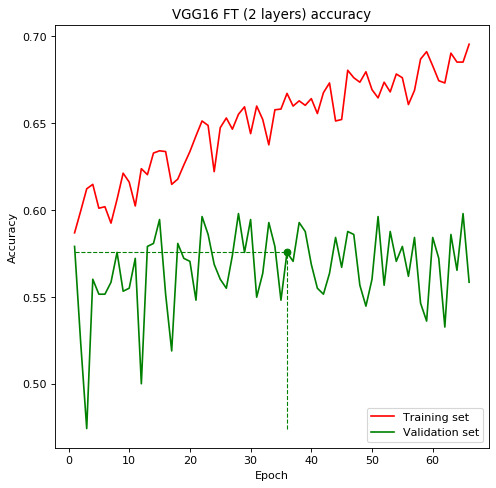

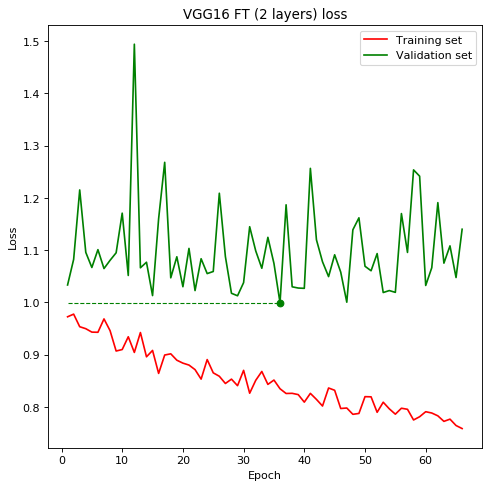

In [57]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [58]:
vgg16_ft_3layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_3layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_3layer.compile(optimizer=RMSprop(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_3layer.summary()
vgg16_ft_3layer.get_layer('vgg16').summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 15,469,316
Non-trainable params: 7,635,264
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)       

In [59]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_3layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [60]:
# Train
history_ft_3layer = vgg16_ft_3layer.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 0.7632 - accuracy: 0.6786
Epoch 00001: val_loss improved from inf to 1.04217, saving model to vgg16_ft_3layer_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 0.7606 - accuracy: 0.6808 - val_loss: 1.0422 - val_accuracy: 0.5790
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 0.7372 - accuracy: 0.6977
Epoch 00002: val_loss improved from 1.04217 to 1.03310, saving model to vgg16_ft_3layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 0.7343 - accuracy: 0.7006 - val_loss: 1.0331 - val_accuracy: 0.5962
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 0.7112 - accuracy: 0.7113
Epoch 00003: val_loss did not improve from 1.03310
19/19 [==============================] - 29s 2s/step - loss: 0.7106 - accuracy: 0.7100 - val_loss: 1.0818 - val_accurac

Epoch 29/200
18/19 [===========================>..] - ETA: 1s - loss: 0.6666 - accuracy: 0.7131
Epoch 00029: val_loss did not improve from 0.99184
19/19 [==============================] - 29s 2s/step - loss: 0.6705 - accuracy: 0.7113 - val_loss: 1.0737 - val_accuracy: 0.5979
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 0.6552 - accuracy: 0.7299
Epoch 00030: val_loss did not improve from 0.99184
19/19 [==============================] - 29s 2s/step - loss: 0.6602 - accuracy: 0.7293 - val_loss: 1.0494 - val_accuracy: 0.5808
Epoch 31/200
18/19 [===========================>..] - ETA: 1s - loss: 0.6816 - accuracy: 0.7249
Epoch 00031: val_loss did not improve from 0.99184
19/19 [==============================] - 29s 2s/step - loss: 0.6803 - accuracy: 0.7250 - val_loss: 1.0719 - val_accuracy: 0.6014
Epoch 32/200
18/19 [===========================>..] - ETA: 1s - loss: 0.6718 - accuracy: 0.7163
Epoch 00032: val_loss did not improve from 0.99184
19/19 [==================

Epoch 59/200
18/19 [===========================>..] - ETA: 1s - loss: 0.6446 - accuracy: 0.7372
Epoch 00059: val_loss did not improve from 0.97064
19/19 [==============================] - 29s 2s/step - loss: 0.6438 - accuracy: 0.7379 - val_loss: 1.0088 - val_accuracy: 0.6117
Epoch 60/200
18/19 [===========================>..] - ETA: 1s - loss: 0.6450 - accuracy: 0.7308
Epoch 00060: val_loss did not improve from 0.97064
19/19 [==============================] - 29s 2s/step - loss: 0.6445 - accuracy: 0.7319 - val_loss: 1.0124 - val_accuracy: 0.6100
Epoch 61/200
18/19 [===========================>..] - ETA: 1s - loss: 0.6465 - accuracy: 0.7399
Epoch 00061: val_loss did not improve from 0.97064
19/19 [==============================] - 29s 2s/step - loss: 0.6455 - accuracy: 0.7396 - val_loss: 1.0548 - val_accuracy: 0.6134
Epoch 62/200
18/19 [===========================>..] - ETA: 1s - loss: 0.6278 - accuracy: 0.7404
Epoch 00062: val_loss did not improve from 0.97064
19/19 [==================

In [65]:
# Save
models.save_model(vgg16_ft_3layer, 'vgg16_ft_3layer_4cl_end.h5')

In [92]:
# History of accuracy and loss
tra_loss_fe = history_ft_3layer.history['loss']
tra_acc_fe = history_ft_3layer.history['accuracy']
val_loss_fe = history_ft_3layer.history['val_loss']
val_acc_fe = history_ft_3layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_3layer = models.load_model('vgg16_ft_3layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (3 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (3 layers)

Epoch [end]: 64
Epoch [opt]: 34
Valid accuracy [end]: 0.5876
Valid accuracy [opt]: 0.6031
Test accuracy [end]:  0.5389
Test accuracy [opt]:  0.5450
Valid loss [end]: 1.1050
Valid loss [opt]: 0.9706
Test loss [end]:  1.9510
Test loss [opt]:  1.9170


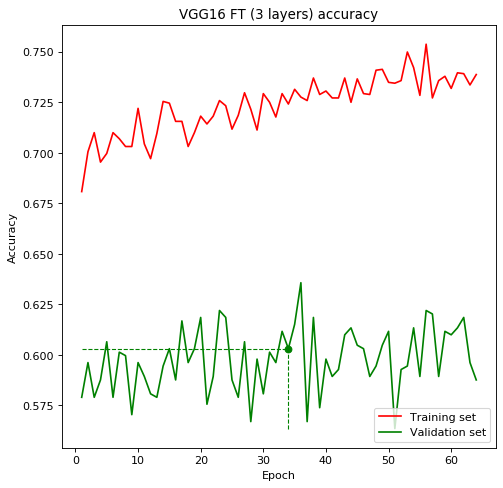

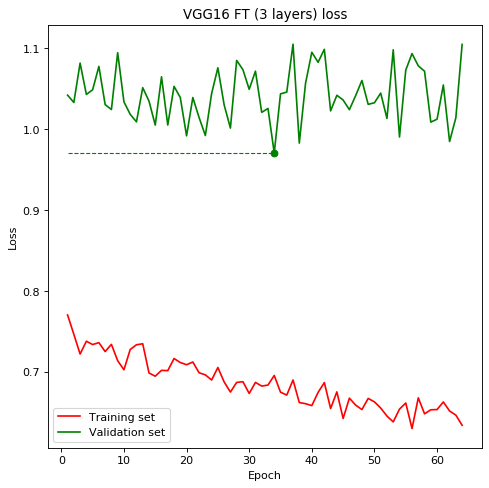

In [93]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();